# **MCBS: Final Project**
## Model 2: transfer learning 
 Pre-trained ResNeXt network provided in:
 
*Matek, C., Schwarz, S., Spiekermann, K.  et al.  Human-level recognition of blast cells in acute myeloid leukaemia with convolutional neural networks.  Nat Mach Intell   1,  538–544 (2019). https://doi.org/10.1038/s42256-019-0101-9*

used on a new dataset containing over 17,000 microscopic images of white blood cells.


*Acevedo, Andrea; Merino, Anna; Alferez, Santiago; Molina, Ángel; Boldú, Laura; Rodellar, José (2020), “A dataset for microscopic peripheral blood cell images for development of automatic recognition systems”, Mendeley Data, V1, doi: 10.17632/snkd93bnjr.1*

In [1]:
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import splitfolders
import shutil
import random
import sys
import os

# custom modules import
import importlib
sys.path.append('../modules')

for cust in ['test_module','residual_network']:
    if cust in sys.modules:
        importlib.reload(sys.modules[cust])
        
import test_module as tm
import residual_network

Using TensorFlow backend.


In [2]:
#set file paths
base_path  = "../data/pbc"
orig_data_path = f"{base_path}/orig"
split_data_path = f"{base_path}/split"

OVERWRITE = True

In [3]:
# set metadata used later in the code
classes_dictionary_org = {'BA': 0, 'EO': 1,'ERB': 2,'IG': 3, 'LY': 4, 'MO': 5,'BNE': 6, 'PLATELET': 7 }
classes_dictionary = {value: key for key, value in classes_dictionary_org.items()}

abbreviation_dict = { 'BA':'basophil', 
                      'EO':'eosinophil',
                      'ERB':'erythroblast',
                      'IG':'ig',
                      'LY':'lymphocyte',
                      'MO':'monocyte',
                      'BNE':'neutrophil',
                      'PLATELET': 'platelet' }

dir_dictionary = {item: classes_dictionary_org[key] for key, item in abbreviation_dict.items()}

shape = 400
img_width, img_height = shape, shape
input_size = (img_width, img_height )

batch_size =  16

if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
else:
        input_shape = (img_width, img_height, 3)

## **1. PREPROCESSING**

### **Stratified split into training, test and validation subsets**

In [4]:
import splitfolders


def create_directory(directory):
    if os.path.exists(directory):
        if OVERWRITE:
            shutil.rmtree(directory)
            os.mkdir(directory)
    else:
        os.mkdir(directory)
        
#create necessery subdirectories
create_directory(split_data_path)

create_directory(f'{split_data_path}/train')
create_directory(f'{split_data_path}/test')
create_directory(f'{split_data_path}/val')

#perform the split
splitfolders.ratio(orig_data_path, output=split_data_path, seed=1234, ratio=(.8,.1,.1)) 

Copying files: 17092 files [00:01, 9979.98 files/s] 


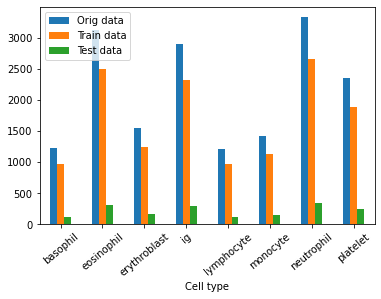

In [5]:
# image count per class after augmentation 

def get_number_of_files(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

data_dist = {}

for class_abbv, class_full in abbreviation_dict.items():
    data_dist[class_abbv] = [class_full,
                             get_number_of_files(f'{orig_data_path}/{class_full}'),
                             get_number_of_files(f'{split_data_path}/train/{class_full}'),
                             get_number_of_files(f'{split_data_path}/test/{class_full}'),
                             get_number_of_files(f'{split_data_path}/val/{class_full}')]
    
data_dist_df = pd.DataFrame.from_dict(data_dist, 'index', columns=['Cell type','Orig data','Train data',
                                                                   'Test data', 'Val data'])

data_dist_df.plot.bar(x= 'Cell type', y=['Orig data', 'Train data', 'Test data'])
plt.xticks(rotation=40)
plt.show()

In [6]:
data_dist_df

,Cell type,Orig data,Train data,Test data,Val data
BA,basophil,1218,974,123,121
EO,eosinophil,3117,2493,313,311
ERB,erythroblast,1551,1240,156,155
IG,ig,2895,2316,290,289
LY,lymphocyte,1214,971,122,121
MO,monocyte,1420,1136,142,142
BNE,neutrophil,3330,2663,334,332
PLATELET,platelet,2348,1878,236,234


### **Create image generators for train, test and validation subsets**

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

train_set = datagen.flow_from_directory(f"{split_data_path}/train/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size,
                                        batch_size = batch_size
                                        )

val_set = datagen.flow_from_directory(f"{split_data_path}/test/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size, 
                                      batch_size = batch_size)

test_set = datagen.flow_from_directory(f"{split_data_path}/test/", 
                                        class_mode = 'categorical', 
                                        target_size = input_size,
                                        batch_size = batch_size,
                                      shuffle = False)


Found 13671 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.


## **2. TRAINING**

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf

### **Pre-trained ResNeXt**

Taking advantage of the similarity of both data sets, the model used in Matek et al. (2019) has been used to classify PBC data. 

In [9]:
model_name = "model2_pbc_1"

epoch_num = 20  # @param {type: "slider", min:1, max:100}

epoch_steps = train_set.samples//batch_size
val_steps = val_set.samples//batch_size

print("\tMODEL SUMMARY: \n")

print(f"Train set:\t\t{train_set.samples} images")
print(f"Test set:\t\t{test_set.samples} images")
print(f"Validation set:\t\t{val_set.samples} images\n")
print(f"Number of epochs:\t{epoch_num}")
print(f"Batch size:\t\t{batch_size}")
print(f"Steps per epoch:\t{epoch_steps}")
print(f"Validation steps:\t{val_steps}")

	MODEL SUMMARY: 

Train set:		13671 images
Test set:		1716 images
Validation set:		1716 images

Number of epochs:	20
Batch size:		16
Steps per epoch:	854
Validation steps:	107


In [10]:
img_height = 400
img_width = 400
img_channels = 3
num_of_classes = 8

base_model = residual_network.residual_network()

weight_file_path = f'../models/resnext_orig/weights.hdf5'
base_model.load_weights(weight_file_path)
base_model.trainable = False 

# get all the layers from pre-trained network apart from the last one 
x = base_model.layers[-2].output

#add last layer adjusted to the new dataset 
network_output = layers.Dense(8, activation='softmax')(x)

#build and compile new model
model = models.Model(inputs=base_model.inputs, outputs=[network_output])


model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.01),
              metrics=["accuracy"])

In [11]:
history = model.fit(
        train_set,
        batch_size=batch_size,
        validation_data = val_set,
        validation_steps = val_steps,
        steps_per_epoch = epoch_steps,
        epochs = epoch_num)

Epoch 1/20
854/854 [==============================] - 176s 206ms/step - loss: 2.1994 - accuracy: 0.2857 - val_loss: 2.1405 - val_accuracy: 0.3224
Epoch 2/20
854/854 [==============================] - 171s 201ms/step - loss: 1.9219 - accuracy: 0.3618 - val_loss: 1.7726 - val_accuracy: 0.3551
Epoch 3/20
854/854 [==============================] - 171s 201ms/step - loss: 1.8058 - accuracy: 0.3961 - val_loss: 1.9070 - val_accuracy: 0.4048
Epoch 4/20
854/854 [==============================] - 171s 201ms/step - loss: 1.7585 - accuracy: 0.4168 - val_loss: 1.7643 - val_accuracy: 0.3756
Epoch 5/20
854/854 [==============================] - 171s 201ms/step - loss: 1.7222 - accuracy: 0.4321 - val_loss: 1.6647 - val_accuracy: 0.4369
Epoch 6/20
854/854 [==============================] - 172s 201ms/step - loss: 1.6810 - accuracy: 0.4507 - val_loss: 1.4697 - val_accuracy: 0.5006
Epoch 7/20
854/854 [==============================] - 171s 201ms/step - loss: 1.6696 - accuracy: 0.4576 - val_loss: 2.4666 -

In [12]:
tm.save_model(model, model_name, history)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/model2_pbc_1/assets


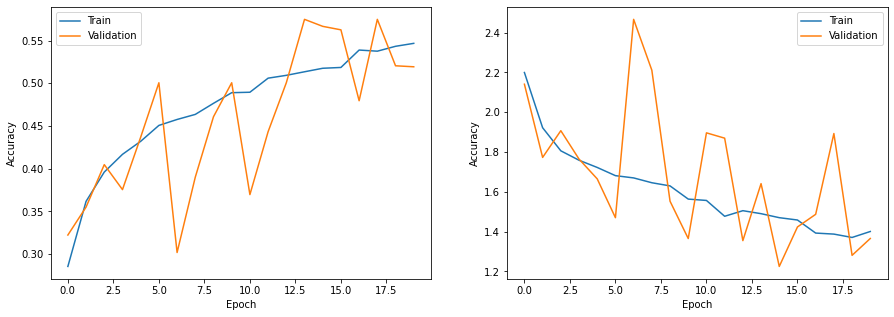

In [13]:
tm.plot_hist(history.history)

In [12]:
test_loss, test_acc  = model.evaluate(test_set)

108/108 [==============================] - 19s 177ms/step - loss: 1.3676 - accuracy: 0.5186


### **Fine-tuning**

In [13]:
model_name = "model2_pbc_fin"

# unfreeze all the layers except for BatchNormalization to fine-tune the network
for layer in model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True
    
#re-compile the model
model.compile(loss="categorical_crossentropy", 
        optimizer=Adam(learning_rate=0.00001),
        metrics=["accuracy"])

In [14]:
epoch_num = 25  # @param {type: "slider", min:1, max:100}

epoch_steps = train_set.samples//batch_size
val_steps = val_set.samples//batch_size

In [ ]:
history2 = model.fit(
        train_set,
        batch_size=batch_size,
        validation_data = val_set,
        validation_steps = val_steps,
        steps_per_epoch = epoch_steps,
        epochs = epoch_num)

Epoch 1/25
854/854 [==============================] - 611s 715ms/step - loss: 0.7562 - accuracy: 0.7369 - val_loss: 0.6184 - val_accuracy: 0.7845
Epoch 2/25
854/854 [==============================] - 606s 709ms/step - loss: 0.5487 - accuracy: 0.8135 - val_loss: 0.4624 - val_accuracy: 0.8475
Epoch 3/25
854/854 [==============================] - 605s 709ms/step - loss: 0.4554 - accuracy: 0.8502 - val_loss: 0.4544 - val_accuracy: 0.8318
Epoch 4/25
854/854 [==============================] - 605s 709ms/step - loss: 0.3993 - accuracy: 0.8740 - val_loss: 0.3773 - val_accuracy: 0.8756
Epoch 5/25
854/854 [==============================] - 605s 709ms/step - loss: 0.3654 - accuracy: 0.8849 - val_loss: 0.3846 - val_accuracy: 0.8692
Epoch 6/25
854/854 [==============================] - 605s 709ms/step - loss: 0.3376 - accuracy: 0.8910 - val_loss: 0.3255 - val_accuracy: 0.8879
Epoch 7/25
854/854 [==============================] - 605s 709ms/step - loss: 0.3122 - accuracy: 0.8995 - val_loss: 0.3321 -

In [17]:
tm.save_model(model, model_name, history2)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/model2_pbc_fin/assets


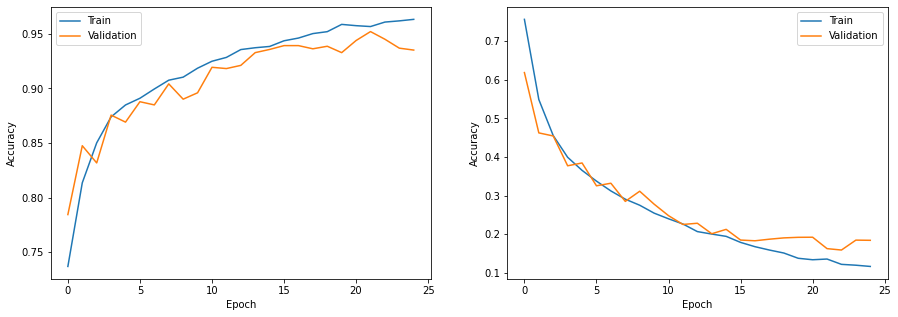

In [18]:
tm.plot_hist(history2.history)

## **3. MODEL EVALUATION**

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import models
from keras import backend as K
from keras.optimizers import Adam

In [20]:
model_name ='model2_pbc_fin'

labels = [abbreviation_dict[classes_dictionary[i]] for i in range(8)]

In [21]:
# executed to run model evaluation in a different session 
# than model's training

if 'model' not in globals():
    
    #load weights and recompile model
    model = models.load_model(f'../models/{model_name}')

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'], 
                  )

In [22]:
test_loss, test_acc  = model.evaluate(test_set)
y_test = test_set.classes
y_pred_prob = model.predict(test_set)
y_pred = y_pred_prob.argmax(axis=1)

108/108 [==============================] - 19s 176ms/step - loss: 0.1840 - accuracy: 0.9353


In [23]:
#class-wise precision and sensitivity

pd.options.display.float_format = '{:,.2f}'.format

df = tm.CM_measures(confusion_matrix(y_test, y_pred), labels=labels)
df[['Precision','Sensitivity', 'Support']]

,Precision,Sensitivity,Support
basophil,1.00,0.89,123
eosinophil,1.00,0.99,313
erythroblast,0.94,0.97,156
ig,0.89,0.84,290
lymphocyte,0.97,0.93,122
monocyte,0.94,0.80,142
neutrophil,0.85,1.00,334
platelet,1.00,0.99,236


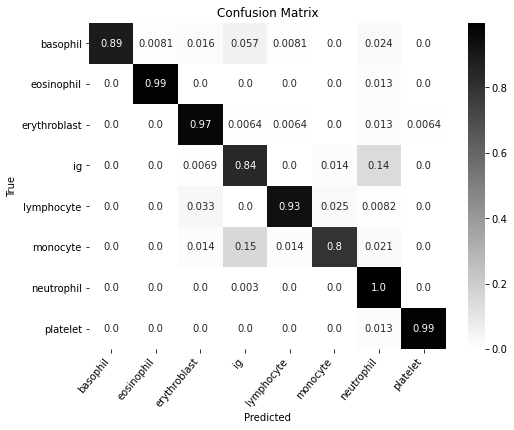

In [24]:
tm.plot_CM_heatmap(y_test, y_pred, labels, save=True, model_nm = model_name, figsize = (8,6))

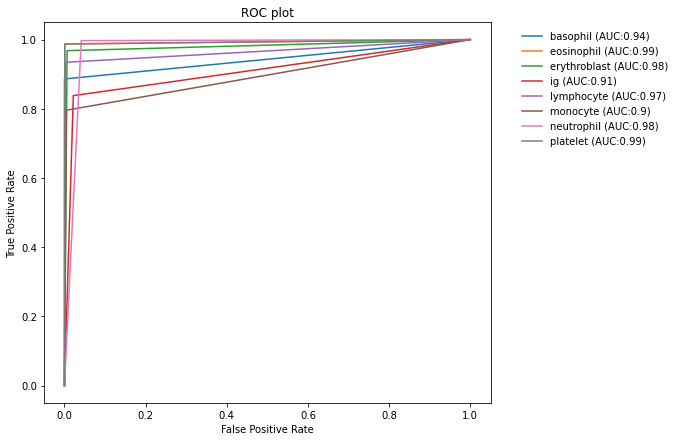

Macro AUC: 0.9572521868839814


In [25]:
tm.plot_multiclass_ROC(y_test, y_pred, labels, figsize=(8,7), save=True, model_nm = model_name)

### **Examples of predictions**

In [30]:
import glob 
from PIL import Image
from keras.preprocessing import image

image_directory =f"{split_data_path}/test/"

files = glob.glob(f"{image_directory}/**/*")
images_list = []
orig_labels = []

for file in files:
    subdirectory, filename = file.split("/")[-2:]
    img1 = Image.open(file)
    img1_resized = img1.resize((400,400))
    x = image.img_to_array(img1_resized)*1./255
    x = np.expand_dims(x, axis=0)
    orig_labels.append(dir_dictionary[subdirectory])
    images_list.append(x)

images = np.vstack(images_list)
preds_probs = model.predict(images, batch_size = 16)

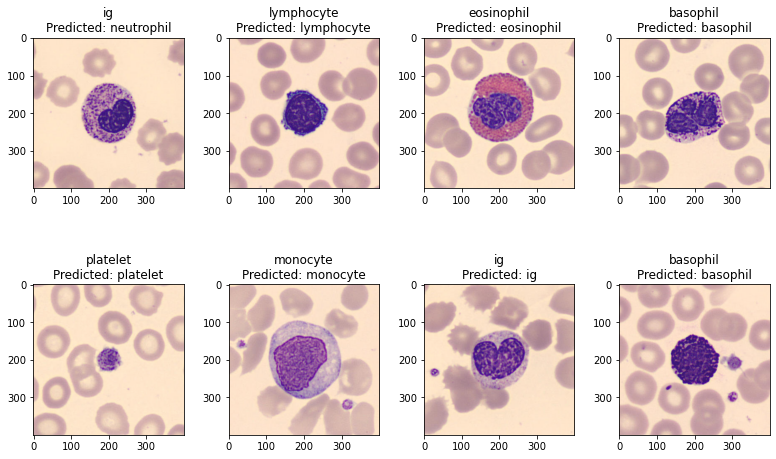

In [31]:
# display 8 images from the test sample along with 
# their predicted classes

indices = [random.randint(0,len(orig_labels)) for i in range(8)]

fig, axs = plt.subplots(2,4, figsize=(11,7))
fig.tight_layout() 

for n,idx in enumerate(indices):
    plt.subplot(2,4,n+1)
    orig  = orig_labels[idx]
    pred = preds_probs.argmax(axis=1)[idx]
    orig = abbreviation_dict[classes_dictionary[orig]]
    pred = abbreviation_dict[classes_dictionary[pred]]
    title = f"{orig}\nPredicted: {pred}"
    plt.title(title)
    plt.imshow(images[idx,:,:,:])

plt.savefig(f"../figures/{model_name}_examples.png")
plt.show()